# Survey Analysis Report

## Overall survey information

In [1]:
import os
import glob

survey_output_dir = "experiment_data"

survey_paths = glob.glob(os.path.join(survey_output_dir, "*.json"))

import json

exp_subjects = []

for survey_path in survey_paths:
    with open(survey_path) as f:
        survey = json.load(f)
        exp_subjects.append(survey)

print("There are", len(survey_paths), "people who have taken the survey.")


There are 10 people who have taken the survey.


In [2]:
import pandas as pd

# Create DataFrame from the experiment subjects
df = pd.DataFrame(exp_subjects)

# Convert timestamp strings to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by timestamp
df = df.sort_values('timestamp')

# Create a new DataFrame with expanded data
data_rows = []
for _, row in df.iterrows():
    session_data = row['data']
    for trial in session_data:
        trial_data = {
            'session_id': row['session_id'],
            'timestamp': row['timestamp'],
            **trial  # unpack all fields from the trial data
        }
        data_rows.append(trial_data)

# Create new DataFrame with expanded trials
trials_df = pd.DataFrame(data_rows)


In [3]:
trials_df = pd.DataFrame(data_rows)

session_lengths = trials_df.groupby('session_id')['time_elapsed'].max()
mean_length = session_lengths.mean()
std_length = session_lengths.std()

print(f"Session length: {mean_length/1000:.2f} ± {std_length/1000:.2f} seconds")
print(f"Or: {mean_length/1000/60:.2f} ± {std_length/1000/60:.2f} minutes")

Session length: 884.90 ± 150.52 seconds
Or: 14.75 ± 2.51 minutes


In [4]:
trials_df = pd.DataFrame(data_rows)

# Filter valid trials
valid_trials = trials_df[(trials_df['rt'] > 15000) & 
                         (trials_df['trial_type'] != 'html-keyboard-response') & 
                         (trials_df['trial_type'] != 'survey-text')]
# Count valid trials
valid_trial_count = len(valid_trials)

print(f"Found {valid_trial_count} valid trials")

Found 206 valid trials


## Subject demographic 

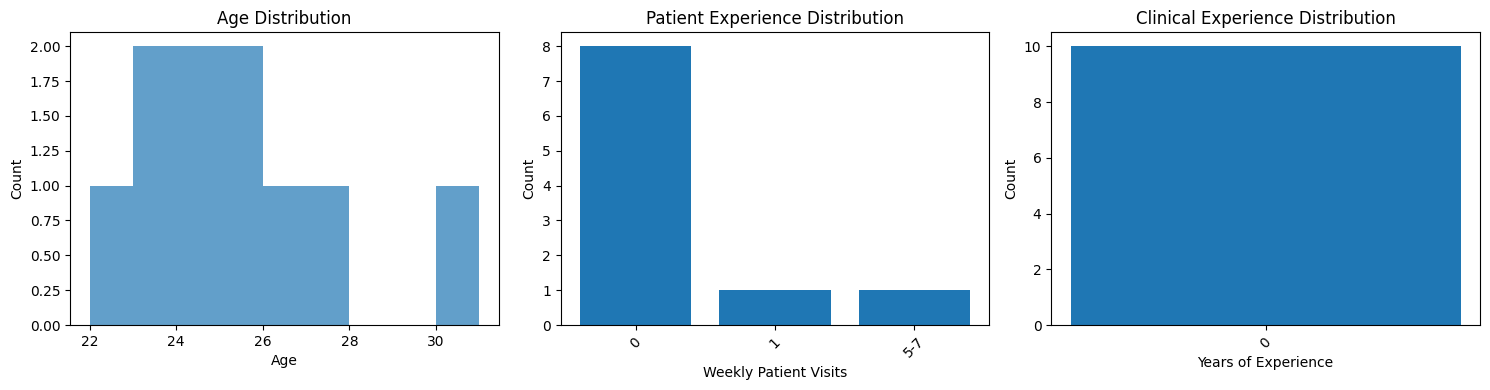

In [12]:
import numpy as np

# Create a copy of the filtered DataFrame
survey_responses = trials_df[(trials_df['trial_type'] == 'survey-text') & (trials_df['questions'].notna())].copy()

# Parse the response column to extract relevant details
# Create new columns from the response dictionary
survey_responses.loc[:, 'user_name'] = survey_responses['response'].apply(lambda x: x['Q0'])
survey_responses.loc[:, 'age'] = survey_responses['response'].apply(lambda x: x['Q1'])
survey_responses.loc[:, 'patient_experience'] = survey_responses['response'].apply(lambda x: x['Q2'])
survey_responses.loc[:, 'clinical_experience'] = survey_responses['response'].apply(lambda x: x['Q3'])

# Create new columns in trials_df for survey information if they don't exist
if 'user_name' not in trials_df.columns:
    trials_df['user_name'] = None
if 'age' not in trials_df.columns:
    trials_df['age'] = None
if 'patient_experience' not in trials_df.columns:
    trials_df['patient_experience'] = None
if 'clinical_experience' not in trials_df.columns:
    trials_df['clinical_experience'] = None

# Fill the survey information back to trials_df
for idx, survey_row in survey_responses.iterrows():
    session_id = survey_row['session_id']
    # Update all rows with matching session_id
    trials_df.loc[trials_df['session_id'] == session_id, 'user_name'] = survey_row['user_name']
    trials_df.loc[trials_df['session_id'] == session_id, 'age'] = survey_row['age']
    trials_df.loc[trials_df['session_id'] == session_id, 'patient_experience'] = survey_row['patient_experience']
    trials_df.loc[trials_df['session_id'] == session_id, 'clinical_experience'] = survey_row['clinical_experience']
    
import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot age distribution
ages = survey_responses['age'].astype(int)
ax1.hist(ages, bins=range(min(ages), max(ages) + 2, 1), alpha=0.7)
ax1.set_title('Age Distribution')
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')

# Plot patient experience distribution
patient_exp_counts = survey_responses['patient_experience'].value_counts()
ax2.bar(range(len(patient_exp_counts)), patient_exp_counts.values)
ax2.set_title('Patient Experience Distribution')
ax2.set_xlabel('Weekly Patient Visits')
ax2.set_ylabel('Count')
ax2.set_xticks(range(len(patient_exp_counts)))
ax2.set_xticklabels(patient_exp_counts.index, rotation=45)

# Plot clinical experience distribution
clinical_exp_counts = survey_responses['clinical_experience'].value_counts()
ax3.bar(range(len(clinical_exp_counts)), clinical_exp_counts.values)
ax3.set_title('Clinical Experience Distribution')
ax3.set_xlabel('Years of Experience')
ax3.set_ylabel('Count')
ax3.set_xticks(range(len(clinical_exp_counts)))
ax3.set_xticklabels(clinical_exp_counts.index, rotation=45)

plt.tight_layout()
plt.show()

## Realistic winrate of Paindiffusion per region and comparison

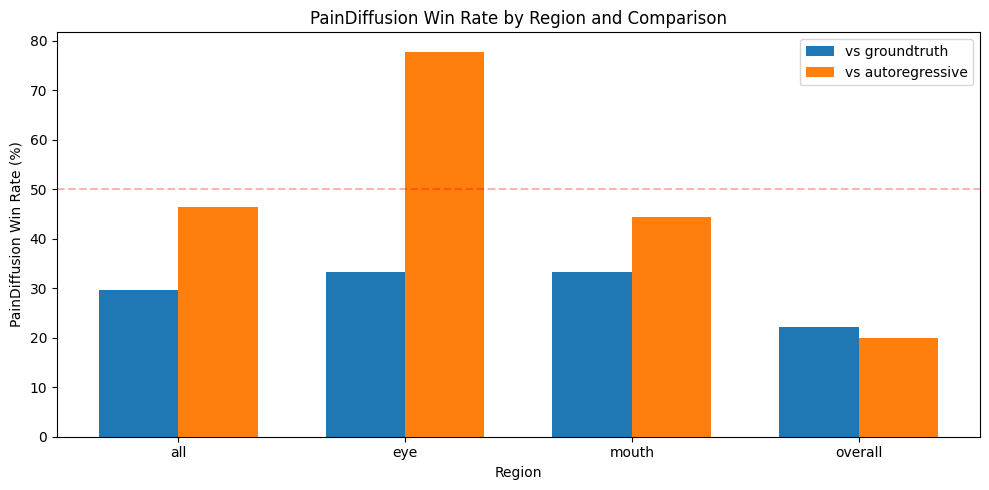

In [6]:
from matplotlib import pyplot as plt
import numpy as np

# Create figure
plt.figure(figsize=(10, 5))

# Define regions and comparison pairs
regions = ['all', 'eye', 'mouth', 'overall']
comparison_pairs = ['paindiffusion_groundtruth', 'paindiffusion_autoregressive']
bar_width = 0.35
x = np.arange(len(regions))

for i, pair in enumerate(comparison_pairs):
    percentages = []
    for region in regions:
        # Filter data for each combination
        condition = (
            (~trials_df['trial_type'].str.contains("html-keyboard-response", na=False)) & 
            (~trials_df['trial_type'].str.contains("survey", na=False)) &
            (trials_df['rt'] >= 15000) & 
            (trials_df['trial_type'].str.contains(pair, na=False))
        )
        if region != 'all':
            condition &= trials_df['trial_type'].str.contains(region, na=False)
            
        filtered_df = trials_df[condition]
        win_rate = (filtered_df['user_selection'] == 'paindiffusion').mean() * 100
        percentages.append(win_rate)
    
    # Plot bars
    plt.bar(x + i*bar_width, percentages, bar_width, 
            label=f'vs {pair.split("_")[1]}')

plt.axhline(y=50, color='r', linestyle='--', alpha=0.3)
plt.ylabel('PainDiffusion Win Rate (%)')
plt.xlabel('Region')
plt.title('PainDiffusion Win Rate by Region and Comparison')
plt.xticks(x + bar_width/2, regions)
plt.legend()
plt.tight_layout()
plt.show()


## Causal relationship of stimuli and reaction

Total lead-following paindiffusion trials: 18
Total lead-following groundtruth trials: 19


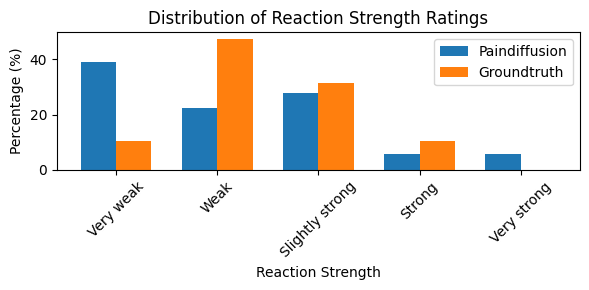

In [7]:
import numpy as np

import matplotlib.pyplot as plt

def analysis_reaction_strength():
    # Create a figure with larger size
    plt.figure(figsize=(6, 3))
    
    # Filter and process data for both conditions
    conditions = ['paindiffusion', 'groundtruth']
    strengths = ['Very weak', 'Weak', 'Slightly strong', 'Strong', 'Very strong']
    
    for i, condition in enumerate(conditions):
        base_condition = (
            (~trials_df['trial_type'].str.contains("html-keyboard-response", regex=False, na=False, case=False)) & 
            (~trials_df['trial_type'].str.contains("survey", regex=False, na=False, case=False)) &
            (trials_df['rt'] >= 15000) & 
            (trials_df['trial_type'].str.contains(f'reaction_strength_{condition}', regex=False, na=False, case=False))
        )
        
        # Get reaction strengths for this condition
        reaction_data = trials_df[base_condition]['user_selection'].value_counts()
        
        # Calculate percentages
        total = reaction_data.sum()
        print(f"Total lead-following {condition} trials: {total}")
        
        percentages = (reaction_data / total) * 100
        
        # Create bar positions
        x = np.arange(len(strengths))
        width = 0.35  # Width of bars
        
        # Plot bars
        plt.bar(x + i*width, 
                [percentages.get(strength, 0) for strength in strengths], 
                width,
                label=condition.capitalize())
    
    # Customize the plot
    plt.xlabel('Reaction Strength')
    plt.ylabel('Percentage (%)')
    plt.title('Distribution of Reaction Strength Ratings')
    plt.xticks(x + width/2, strengths, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

analysis_reaction_strength()

## Diversity of movement per region 

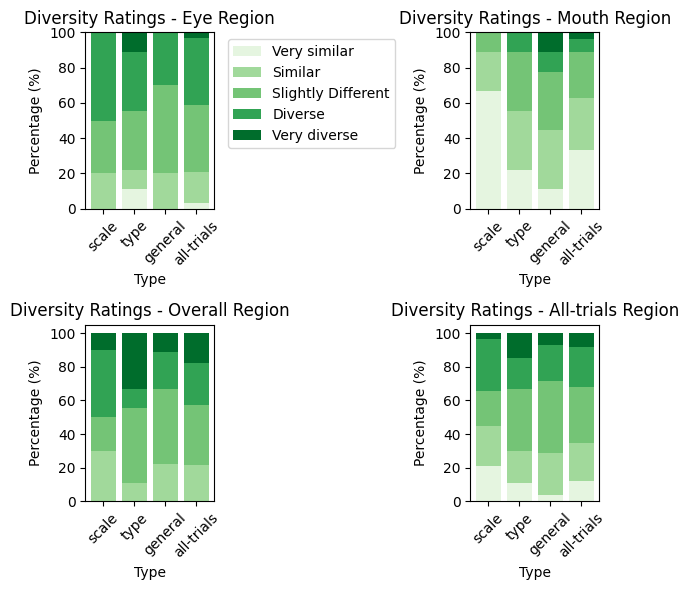

In [13]:
regions = ['eye', 'mouth', 'overall', 'all-trials']
types = ['scale', 'type', 'general', 'all-trials']
user_options = ['Very similar', 'Similar', 'Slightly Different', 'Diverse', 'Very diverse']

# Define color gradient from light to dark green
colors = ['#e5f5e0', '#a1d99b', '#74c476', '#31a354', '#006d2c']

def analysis_diversity(region, type):
    # Function body remains the same as before
    base_condition = (
        (~trials_df['trial_type'].str.contains("html-keyboard-response", regex=False, na=False, case=False)) & 
        (~trials_df['trial_type'].str.contains("survey", regex=False, na=False, case=False)) &
        (trials_df['rt'] >= 15000)
    )
    
    if region == 'all-trials' and type == 'all-trials':
        condition = base_condition & (trials_df['trial_type'].str.contains('diversity', regex=False, na=False, case=False))
    elif region == 'all-trials':
        condition = base_condition & (trials_df['trial_type'].str.contains(f'diversity_{type}', regex=False, na=False, case=False))
    elif type == 'all-trials':
        condition = base_condition & (
            trials_df['trial_type'].str.contains('diversity', regex=False, na=False, case=False) &
            trials_df['trial_type'].str.contains(region, regex=False, na=False, case=False)
        )
    else:
        condition = base_condition & (trials_df['trial_type'].str.contains(f'diversity_{type}_{region}', regex=False, na=False, case=False))
    
    return trials_df[condition]

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes = axes.flatten()

for idx, region in enumerate(regions):
    diversity_data = []
    labels = []
    
    for type_name in types:
        trials = analysis_diversity(region, type_name)
        if len(trials) > 0:
            counts = trials['user_selection'].value_counts()
            percentages = (counts / len(trials) * 100).reindex(user_options, fill_value=0)
            diversity_data.append(percentages)
            labels.append(f"{type_name}")
    
    x = np.arange(len(labels))
    bottom = np.zeros(len(labels))
    
    for i, option in enumerate(user_options):
        values = [data[option] if option in data else 0 for data in diversity_data]
        axes[idx].bar(x, values, bottom=bottom, label=option, color=colors[i])
        bottom += values
    
    axes[idx].set_title(f'Diversity Ratings - {region.capitalize()} Region')
    axes[idx].set_xlabel('Type')
    axes[idx].set_ylabel('Percentage (%)')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(labels, rotation=45)
    
    if idx == 0:
        axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## Overall winrate of paindiffusion and groundtruth with and without label

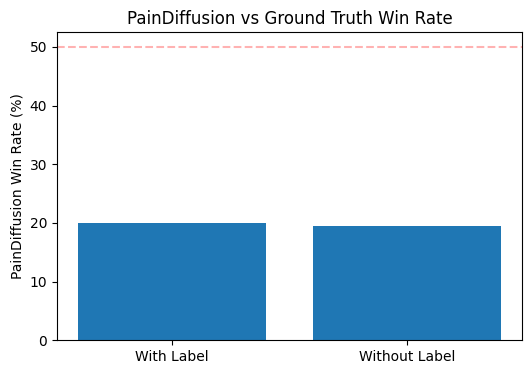

In [9]:
def analysis_overall(with_label):
    condition = (
        (~trials_df['trial_type'].str.contains("html-keyboard-response", regex=False, na=False, case=False)) & 
        (~trials_df['trial_type'].str.contains("survey", regex=False, na=False, case=False)) &
        (trials_df['rt'] >= 15000)
    )
    
    if with_label:
        condition &= trials_df['trial_type'].str.contains('overall_with_label', regex=False, na=False, case=False)
    else:
        condition &= trials_df['trial_type'].str.contains('overall', regex=False, na=False, case=False)
        
    return trials_df[condition]

# Get data for both conditions
with_label_trials = analysis_overall(True)
without_label_trials = analysis_overall(False)

# Calculate win rates
win_rate_with = (with_label_trials['user_selection'].isin(['paindiffusion', 'Machine generated'])).mean() * 100
win_rate_without = (without_label_trials['user_selection'].isin(['paindiffusion', 'Machine generated'])).mean() * 100

# Create bar plot
plt.figure(figsize=(6, 4))
plt.bar(['With Label', 'Without Label'], [win_rate_with, win_rate_without])
plt.axhline(y=50, color='r', linestyle='--', alpha=0.3)
plt.ylabel('PainDiffusion Win Rate (%)')
plt.title('PainDiffusion vs Ground Truth Win Rate')
plt.show()

# User detail feedback

In [11]:
user_options = ['Real human', 'Machine generated']

# print all reason for the answer the user choose paindiffusion or machine generated
def analysis_reasons(user_choice):
    # Filter data for both conditions
    base_condition = (
        (~trials_df['trial_type'].str.contains("survey", regex=False, na=False, case=False)) &
        (trials_df['rt'] >= 15000)
    )
    
    condition = base_condition & trials_df['trial_type'].str.contains('overall_with_label', regex=False, na=False, case=False)
    overall_trials = trials_df[condition]

    # Get responses to "Why?" questions
    reason_condition = (
        (trials_df['trial_type'].str.contains("survey", regex=False, na=False, case=False)) & 
        (trials_df['trial_index'].isin(overall_trials['trial_index'] + 1))
    )
    
    # Filter for trials where user chose the specified option
    selected_trials = overall_trials[overall_trials['user_selection'] == user_choice]
    
    # Get corresponding reasons
    for _, trial in selected_trials.iterrows():
        reason = trials_df[
            reason_condition & 
            (trials_df['session_id'] == trial['session_id'])
        ]['response'].iloc[0]
        
        if isinstance(reason, dict) and 'Q0' in reason:
            print(f"User {trial['user_name']}: {reason['Q0']}")

print("Reasons for choosing Real Human:")        
analysis_reasons(user_options[0])
print("Reasons for choosing Machine Generated:")
analysis_reasons(user_options[1])


Reasons for choosing Real Human:
User Shimizu: 口周りの筋肉の動きの量が多かった
User Vinh: Expression is more natural. Machine generated is too static.
User Bui Huy Hoang: I feel the real human model can show the nose scrunch, the machine generated one can not.
User Kaito Kawai: 人がしかめっ面になる部分や，口が状況に応じて動いていると感じたから．
User 峯崎 翔琉: 震えや表情の変化から、痛みへの恐怖を感じられたから
User 藤井康之: 表情の遷移が自然であると感じたから
User 松下 優希: 刺激を受けたと思われるタイミングで，眉が下がり，目を細め，口を結んだ様子が自然に見えた
User Nishikori Yuhi: 細かい表情変化があったため
Reasons for choosing Machine Generated:
User Nguyen Tri Tung Nguyen: 生成された表現があまりにもドラスティックすぎる
User Suzuki Yusuke: 反応が頻繁に表れているため


English-translation

Reasons for choosing Real Human:

- User Shimizu: There was a large amount of movement in the muscles around the mouth.
- User Vinh: The expression is more natural. The machine-generated one is too static.
- User Bui Huy Hoang: I feel that the real human model can show the nose scrunch, but the machine-generated one cannot.
- User Kaito Kawai: I felt that the person's face grimaced and the mouth moved according to the situation.
- User Shoru Minezaki: The trembling and changes in expression conveyed a sense of fear towards the pain.
- User Yasuyuki Fujii: The transitions between expressions felt natural.
- User Yuki Matsushita: At the moment when the stimulus seemed to be received, the eyebrows lowered, the eyes squinted, and the mouth was closed naturally.
- User Yuhi Nishikori: There were subtle changes in expression.

Reasons for choosing Machine Generated:

- User Nguyen Tri Tung Nguyen: The generated expression was overly drastic.
- User Yusuke Suzuki: The reactions appeared frequently.